# Machine Learning Engineer Nanodegree
## Introduction and Foundations
## Project: Capstone Austin Animal Intake and Outcomes



In [289]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames
from time import time

# Pretty display for notebooks
%matplotlib inline

pd.set_option('display.max_columns', None)
# Load the dataset
in_file = 'aac_intakes_outcomes.csv'
intakes_outcomes_data = pd.read_csv(in_file)

# Print the first few entries of the intake and outcomes data
display(intakes_outcomes_data.head(n=1))


,age_upon_outcome,animal_id_outcome,date_of_birth,outcome_subtype,outcome_type,sex_upon_outcome,age_upon_outcome_(days),age_upon_outcome_(years),age_upon_outcome_age_group,outcome_datetime,outcome_month,outcome_year,outcome_monthyear,outcome_weekday,outcome_hour,outcome_number,dob_year,dob_month,dob_monthyear,age_upon_intake,animal_id_intake,animal_type,breed,color,found_location,intake_condition,intake_type,sex_upon_intake,count,age_upon_intake_(days),age_upon_intake_(years),age_upon_intake_age_group,intake_datetime,intake_month,intake_year,intake_monthyear,intake_weekday,intake_hour,intake_number,time_in_shelter,time_in_shelter_days
0,10 years,A006100,7/9/2007 0:00,NaN,Return to Owner,Neutered Male,3650,10.0,"(7.5, 10.0]",12/7/2017 14:07,12,2017,2017-12,Thursday,0,1,2007,7,2017-12,10 years,A006100,Dog,Spinone Italiano Mix,Yellow/White,Colony Creek And Hunters Trace in Austin (TX),Normal,Stray,Neutered Male,1,3650,10.0,"(7.5, 10.0]",12/7/2017 0:00,12,2017,2017-12,Thursday,14,1,0 days 14:07:00.000000000,0.588194


In [290]:
intakes_outcomes_data.intake_month=intakes_outcomes_data.intake_month.astype('int')
intakes_outcomes_data['Q1']=intakes_outcomes_data['intake_month'].apply(lambda x: '1' if x <= 3. else '0')
intakes_outcomes_data['Q2'] = intakes_outcomes_data['intake_month'].apply(lambda x: '1' if (x > 3. and x <= 6.) else '0')
intakes_outcomes_data['Q3'] = intakes_outcomes_data['intake_month'].apply(lambda x: '1' if (x > 6. and x <= 9.) else '0')
intakes_outcomes_data['Q4'] = intakes_outcomes_data['intake_month'].apply(lambda x: '1' if (x > 9.and x <= 12.) else '0')
intakes_outcomes_data.Q1=intakes_outcomes_data.Q1.astype('int')
intakes_outcomes_data.Q2=intakes_outcomes_data.Q2.astype('int')
intakes_outcomes_data.Q3=intakes_outcomes_data.Q3.astype('int')
intakes_outcomes_data.Q4=intakes_outcomes_data.Q4.astype('int')
#intakes_outcomes_data=intakes_outcomes_data.drop(['intake_month'],axis=1)

intakes_outcomes_data['outcome_year'] = intakes_outcomes_data['outcome_year'].astype(int)
intakes_outcomes_data['outcome_month'] = intakes_outcomes_data['outcome_month'].astype(int)
intakes_outcomes_data['outcome_hour'] = intakes_outcomes_data['outcome_hour'].astype(int)
intakes_outcomes_data.sort_values(by=['outcome_year', 'outcome_month', 'outcome_hour'],inplace=True)
intakes_outcomes_data['PastIntake']=intakes_outcomes_data.duplicated('animal_id_outcome',keep='last')
intakes_outcomes_data['PastIntake'] = intakes_outcomes_data['PastIntake'].astype(int)

intakes_outcomes_data['age_upon_intake_(years)']=intakes_outcomes_data['age_upon_intake_(years)'].astype(float)

In [291]:
def numday_stats(df,threshold):
    
    n_records = df.shape[0]
    n_greater_days = df[df.under_days==1].shape[0]
    n_at_most_days = df[df.under_days==0].shape[0]
    greater_percent =  ( float(n_greater_days) / float(n_records) ) * 100.

    # Print the results
    print("Total number of records: {}".format(n_records))
    print("Individuals staying more then n days: {}".format(n_greater_days))
    print("Individuals staying at most n days: {}".format(n_at_most_days))
    print("Percentage of individuals staying less than ",threshold," days: {}%".format(greater_percent))
    return

In [394]:
def dout_by_type(din,type,threshold):
    data = din
    data = data.drop(['intake_month','outcome_subtype','animal_id_outcome','animal_id_intake','time_in_shelter','age_upon_outcome','sex_upon_outcome','age_upon_outcome_(years)','found_location','count','intake_year','intake_number','date_of_birth', 'age_upon_intake_(days)','dob_monthyear','intake_datetime','intake_hour','intake_monthyear','time_in_shelter','dob_month','outcome_month','age_upon_intake','age_upon_intake_age_group','age_upon_outcome_(days)','age_upon_outcome_age_group','outcome_datetime','outcome_year', 'outcome_monthyear','outcome_weekday','outcome_hour','outcome_number','dob_year','intake_weekday'], axis=1)
    # Constraint
    data=data[data.intake_condition=='Normal']
    # Outliers
    data=data[data.sex_upon_intake!='Unknown']
    data=data[data.outcome_type!='Missing']
    data=data[data.outcome_type!='Died']
    data=data[data.outcome_type!='Disposal']
    data=data[data.animal_type==type]
    data = data.drop(['intake_condition'],axis=1)
        
    # Getting relevant fields into correct numerical datatype
    data.time_in_shelter_days = data.time_in_shelter_days.astype(float)
    #only look at data after required 72 hour stay expires
    #data=data[data.time_in_shelter_days>3]
        
    data = data.sample(frac=1).reset_index(drop=True)
    
    #data['time_in_shelter_weeks'] = round(data['time_in_shelter_days'] / 7)
    #data['time_in_shelter_weeks'] = data['time_in_shelter_weeks'].clip(upper=4)
    data['under_days']=(data.time_in_shelter_days<=threshold-3)
    
    outcome_type_pd= pd.get_dummies(data['outcome_type'],prefix='OT')
    outcome_type_pd=outcome_type_pd.astype('int')
    
    intake_type_pd= pd.get_dummies(data['intake_type'],prefix='IT')
    intake_type_pd=intake_type_pd.astype('int')
    
    data['sex_upon_intake']=data['sex_upon_intake'].replace(regex=True,to_replace=' Male',value="")
    data['sex_upon_intake']=data['sex_upon_intake'].replace(regex=True,to_replace=' Female',value="")
    data['sex_upon_intake']=data['sex_upon_intake'].replace(regex=True,to_replace='Neutered',value="Altered")
    data['sex_upon_intake']=data['sex_upon_intake'].replace(regex=True,to_replace='Spayed',value="Altered")
    sex_upon_intake_pd=pd.get_dummies(data['sex_upon_intake'])
    sex_upon_intake_pd=sex_upon_intake_pd.astype('int')

    color_labels_list=[]
    color_consolidate_list=[]
    color_keep_list=[]
    color_labels_pd=data['color'].str.get_dummies(sep='/').add_prefix('C_')
    color_labels_pd=color_labels_pd.astype('int')
    color_labels_pd_copy=color_labels_pd.copy()
    labels=color_labels_pd_copy.std().sort_values()
    labels=color_labels_pd.sum()
    # For statistical signficance
    #labels=labels[labels>300]
    labels=labels[labels>=.5]
    color_keep_list=labels.index.tolist()
    color_labels_list=color_labels_pd.columns.tolist() 
    color_consolidate_list = [x for x in color_labels_list if x not in color_keep_list]
    color_labels_pd['C_rarecolor']=0
    for column_name, column in color_labels_pd.transpose().iterrows(): 
        if column_name in color_consolidate_list:
            color_labels_pd['C_rarecolor']=color_labels_pd.C_rarecolor.add(column, fill_value=0)
            color_labels_pd=color_labels_pd.drop(column_name,axis=1)
    color_labels_pd['C_rarecolor'] = color_labels_pd['C_rarecolor'].clip(upper=1)
    color_labels_pd['C_common']=0
    for i in color_keep_list:
        color_labels_pd['C_common']=color_labels_pd[i] | color_labels_pd['C_common']
    for i in range(0,color_labels_pd.shape[0]):
        if color_labels_pd.loc[i,'C_rarecolor']==1:
            color_labels_pd.loc[i,'C_rarecolor']=not color_labels_pd.loc[i,'C_common']
    color_labels_pd=color_labels_pd.astype('int')

    data['Mix'] = [1 if 'Mix' in x else 0 for x in data['breed']] 
    data.Mix = data.Mix.astype(int)
    data['breed']=data['breed'].str.replace('Mix',"")
    data['breed']=data['breed'].str.replace(' ',"")
    breed_labels_list=[]
    breed_consolidate_list=[]
    breed_keep_list=[]
    breed_labels_pd = data['breed'].str.get_dummies(sep='/').add_prefix('B_')
    breed_labels_pd=breed_labels_pd.astype('int')
    breed_labels_pd_copy=breed_labels_pd.copy()
    labels=breed_labels_pd.std().sort_values()
    labels=breed_labels_pd.sum()
    # For statistical signficance
    #labels=labels[labels>100]
    labels=labels[labels>=.25]
    breed_labels_list=breed_labels_pd.columns.tolist()
    breed_keep_list=labels.index.tolist()
    breed_consolidate_list = [x for x in breed_labels_list if x not in breed_keep_list]
    breed_labels_pd['B_rarebreed']=0
    for column_name, column in breed_labels_pd.transpose().iterrows(): 
        if column_name in breed_consolidate_list:
            breed_labels_pd['B_rarebreed']=breed_labels_pd.B_rarebreed.add(column, fill_value=0)
            breed_labels_pd=breed_labels_pd.drop(column_name,axis=1)
    breed_labels_pd['B_rarebreed'] = breed_labels_pd['B_rarebreed'].clip(upper=1)
    breed_labels_pd['B_common']=0
    for i in breed_keep_list:
        breed_labels_pd['B_common']=breed_labels_pd[i] | breed_labels_pd['B_common']
    for i in range(0,breed_labels_pd.shape[0]):
        if breed_labels_pd.loc[i,'B_rarebreed']==1:
            breed_labels_pd.loc[i,'B_rarebreed']=not breed_labels_pd.loc[i,'B_common']
    breed_labels_pd=breed_labels_pd.astype('int')
    
    dataO=pd.concat([data,outcome_type_pd,sex_upon_intake_pd,intake_type_pd,breed_labels_pd],axis=1)
    dataO=dataO.drop(['B_common','Q1','Q2','Q3','Q4','Mix','Altered','Intact','breed','time_in_shelter_days', \
                      'animal_type','color','sex_upon_intake','outcome_type',\
                      'intake_type','IT_Owner Surrender','IT_Public Assist','IT_Euthanasia Request'],axis=1)
    #temporarily remove outcome type from drop list
    #dataO=dataO.drop(['breed'],axis=1)
    dataO=dataO.drop(dataO.filter(regex=("OT")),axis=1)
    
    #dataO = dataO.iloc[dataO.isnull().sum(1).sort_values.index]
    #dataO=dataO.dropna()
    #dataO = dataO.loc[:, (dataO != False).any(axis=0)]
    dataO = dataO.sample(frac=1).reset_index(drop=True)
    #dataO.head(n=4)

    return dataO

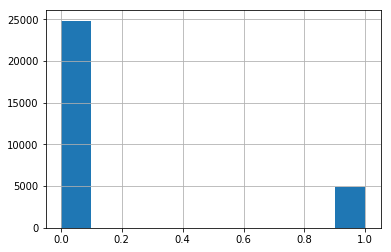

In [259]:
dataDog['B_PitBull'].hist()

In [395]:
#dataDog=dout_by_type(intakes_outcomes_data,'Dog')
threshold=30
dataDog=dout_by_type(intakes_outcomes_data,'Dog',threshold)
numday_stats(dataDog,threshold)

Total number of records: 41340
Individuals staying more then n days: 36324
Individuals staying at most n days: 5016
Percentage of individuals staying less than  30  days: 87.86647314949202%


In [ ]:
dataDog.sum()

#Cost of saving a life
11627*3
#3:11627*3=34881
#7: 18239*7 = 127673
#14: 22484*14 = 314776
#21 24144*21 = 507024
#28 25291*28 = 708148

intakes_outcomes_data[intakes_outcomes_data.outcome_type=='Adoption'].describe()

In [396]:
#outcome_raw=dataDog['time_in_shelter_days']
outcome_raw=dataDog['under_days']
features_raw=dataDog.drop(['under_days'],axis=1)



In [397]:
# Log-transform the skewed features
skewed = ['age_upon_intake_(years)']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))


In [398]:
display(features_log_transformed.head(n=1))

,age_upon_intake_(years),PastIntake,IT_Stray,B_Affenpinscher,B_AfghanHound,B_AiredaleTerrier,B_Akbash,B_Akita,B_AlaskanHusky,B_AlaskanMalamute,B_AmericanBulldog,B_AmericanEskimo,B_AmericanFoxhound,B_AmericanPitBullTerrier,B_AmericanStaffordshireTerrier,B_AnatolShepherd,B_AustralianCattleDog,B_AustralianKelpie,B_AustralianShepherd,B_AustralianTerrier,B_Basenji,B_BassetHound,B_Beagle,B_BeardedCollie,B_Beauceron,B_BedlingtonTerr,B_BelgianMalinois,B_BelgianSheepdog,B_BelgianTervuren,B_BerneseMountainDog,B_BichonFrise,B_Black,B_BlackMouthCur,B_Bloodhound,B_BlueLacy,B_BluetickHound,B_Boerboel,B_BorderCollie,B_BorderTerrier,B_Borzoi,B_BostonTerrier,B_BouvFlandres,B_Boxer,B_BoykinSpan,B_Brittany,B_BrussGriffon,B_BullTerrier,B_BullTerrierMiniature,B_Bulldog,B_Bullmastiff,B_CairnTerrier,B_CanaanDog,B_CaneCorso,B_CardiganWelshCorgi,B_CarolinaDog,B_Catahoula,B_CavalierSpan,B_ChesaBayRetr,B_ChihuahuaLonghair,B_ChihuahuaShorthair,B_ChineseCrested,B_ChineseSharpei,B_ChowChow,B_Cirneco,B_CockerSpaniel,B_CollieRough,B_CollieSmooth,B_CotonDeTulear,B_Dachshund,B_DachshundLonghair,B_DachshundStan,B_DachshundWirehair,B_Dalmatian,B_DandieDinmont,B_DobermanPinsch,B_DogoArgentino,B_DogueDeBordeaux,B_DutchShepherd,B_EngToySpaniel,B_EnglishBulldog,B_EnglishCockerSpaniel,B_EnglishCoonhound,B_EnglishFoxhound,B_EnglishPointer,B_EnglishSetter,B_EnglishShepherd,B_EnglishSpringerSpaniel,B_Entlebucher,B_Feist,B_FieldSpaniel,B_FinnishSpitz,B_FlatCoatRetriever,B_FrenchBulldog,B_GermanPinscher,B_GermanShepherd,B_GermanShorthairPointer,B_GermanWirehairedPointer,B_GlenOfImaal,B_GoldenRetriever,B_GordonSetter,B_GrandBassetGriffonVendeen,B_GreatDane,B_GreatPyrenees,B_GreaterSwissMountainDog,B_Greyhound,B_Harrier,B_Havanese,B_Hovawart,B_IbizanHound,B_IrishSetter,B_IrishTerrier,B_IrishWolfhound,B_ItalianGreyhound,B_JackRussellTerrier,B_JapaneseChin,B_Jindo,B_Kangal,B_Keeshond,B_Kuvasz,B_LabradorRetriever,B_LakelandTerrier,B_Landseer,B_Leonberger,B_LhasaApso,B_Lowchen,B_Maltese,B_ManchesterTerrier,B_Mastiff,B_MexicanHairless,B_MiniaturePinscher,B_MiniaturePoodle,B_MiniatureSchnauzer,B_NeapolitanMastiff,B_Newfoundland,B_NorfolkTerrier,B_NorwegianElkhound,B_NorwichTerrier,B_NovaScotiaDuckTollingRetriever,B_OldEnglishBulldog,B_OldEnglishSheepdog,B_Otterhound,B_Papillon,B_ParsonRussellTerrier,B_PatterdaleTerr,B_Pbgv,B_Pekingese,B_PembrokeWelshCorgi,B_PharaohHound,B_PicardySheepdog,B_PitBull,B_PlottHound,B_PodengoPequeno,B_Pointer,B_Pomeranian,B_PortWaterDog,B_PresaCanario,B_Pug,B_QueenslandHeeler,B_RatTerrier,B_RedboneHound,B_RhodRidgeback,B_Rottweiler,B_Saluki,B_Samoyed,B_Schipperke,B_SchnauzerGiant,B_ScottishTerrier,B_SealyhamTerr,B_ShetlandSheepdog,B_ShibaInu,B_ShihTzu,B_SiberianHusky,B_SilkyTerrier,B_SkyeTerrier,B_SmoothFoxTerrier,B_SoftCoatedWheatenTerrier,B_SpanishMastiff,B_SpanishWaterDog,B_SpinoneItaliano,B_St.BernardRoughCoat,B_St.BernardSmoothCoat,B_Staffordshire,B_StandardPoodle,B_StandardSchnauzer,B_SussexSpan,B_SwedishVallhund,B_SwissHound,B_TanHound,B_TibetanSpaniel,B_TibetanTerrier,B_ToyFoxTerrier,B_ToyPoodle,B_TreeingCur,B_TreeingTennesseBrindle,B_TreeingWalkerCoonhound,B_Unknown,B_Vizsla,B_Weimaraner,B_WelshSpringerSpaniel,B_WelshTerrier,B_WestHighland,B_Whippet,B_WireHairFoxTerrier,B_WirehairedPointingGriffon,B_Yorkshire,B_YorkshireTerrier,B_rarebreed
0,0.2204,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [399]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_log_transformed, 
                                                    outcome_raw, 
                                                    test_size = 0.2, 
                                                    random_state = 0)
X_train=X_train.astype('int')
X_test=X_test.astype('int')
y_train=y_train.astype('int')
y_test=y_test.astype('int')


# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

#print(y_train)

Training set has 33072 samples.
Testing set has 8268 samples.


In [400]:
outcome_raw.describe()

count     41340
unique        2
top        True
freq      36324
Name: under_days, dtype: object

In [401]:
dataDog[dataDog['B_YorkshireTerrier']==1].describe()

,age_upon_intake_(years),PastIntake,IT_Stray,B_Affenpinscher,B_AfghanHound,B_AiredaleTerrier,B_Akbash,B_Akita,B_AlaskanHusky,B_AlaskanMalamute,B_AmericanBulldog,B_AmericanEskimo,B_AmericanFoxhound,B_AmericanPitBullTerrier,B_AmericanStaffordshireTerrier,B_AnatolShepherd,B_AustralianCattleDog,B_AustralianKelpie,B_AustralianShepherd,B_AustralianTerrier,B_Basenji,B_BassetHound,B_Beagle,B_BeardedCollie,B_Beauceron,B_BedlingtonTerr,B_BelgianMalinois,B_BelgianSheepdog,B_BelgianTervuren,B_BerneseMountainDog,B_BichonFrise,B_Black,B_BlackMouthCur,B_Bloodhound,B_BlueLacy,B_BluetickHound,B_Boerboel,B_BorderCollie,B_BorderTerrier,B_Borzoi,B_BostonTerrier,B_BouvFlandres,B_Boxer,B_BoykinSpan,B_Brittany,B_BrussGriffon,B_BullTerrier,B_BullTerrierMiniature,B_Bulldog,B_Bullmastiff,B_CairnTerrier,B_CanaanDog,B_CaneCorso,B_CardiganWelshCorgi,B_CarolinaDog,B_Catahoula,B_CavalierSpan,B_ChesaBayRetr,B_ChihuahuaLonghair,B_ChihuahuaShorthair,B_ChineseCrested,B_ChineseSharpei,B_ChowChow,B_Cirneco,B_CockerSpaniel,B_CollieRough,B_CollieSmooth,B_CotonDeTulear,B_Dachshund,B_DachshundLonghair,B_DachshundStan,B_DachshundWirehair,B_Dalmatian,B_DandieDinmont,B_DobermanPinsch,B_DogoArgentino,B_DogueDeBordeaux,B_DutchShepherd,B_EngToySpaniel,B_EnglishBulldog,B_EnglishCockerSpaniel,B_EnglishCoonhound,B_EnglishFoxhound,B_EnglishPointer,B_EnglishSetter,B_EnglishShepherd,B_EnglishSpringerSpaniel,B_Entlebucher,B_Feist,B_FieldSpaniel,B_FinnishSpitz,B_FlatCoatRetriever,B_FrenchBulldog,B_GermanPinscher,B_GermanShepherd,B_GermanShorthairPointer,B_GermanWirehairedPointer,B_GlenOfImaal,B_GoldenRetriever,B_GordonSetter,B_GrandBassetGriffonVendeen,B_GreatDane,B_GreatPyrenees,B_GreaterSwissMountainDog,B_Greyhound,B_Harrier,B_Havanese,B_Hovawart,B_IbizanHound,B_IrishSetter,B_IrishTerrier,B_IrishWolfhound,B_ItalianGreyhound,B_JackRussellTerrier,B_JapaneseChin,B_Jindo,B_Kangal,B_Keeshond,B_Kuvasz,B_LabradorRetriever,B_LakelandTerrier,B_Landseer,B_Leonberger,B_LhasaApso,B_Lowchen,B_Maltese,B_ManchesterTerrier,B_Mastiff,B_MexicanHairless,B_MiniaturePinscher,B_MiniaturePoodle,B_MiniatureSchnauzer,B_NeapolitanMastiff,B_Newfoundland,B_NorfolkTerrier,B_NorwegianElkhound,B_NorwichTerrier,B_NovaScotiaDuckTollingRetriever,B_OldEnglishBulldog,B_OldEnglishSheepdog,B_Otterhound,B_Papillon,B_ParsonRussellTerrier,B_PatterdaleTerr,B_Pbgv,B_Pekingese,B_PembrokeWelshCorgi,B_PharaohHound,B_PicardySheepdog,B_PitBull,B_PlottHound,B_PodengoPequeno,B_Pointer,B_Pomeranian,B_PortWaterDog,B_PresaCanario,B_Pug,B_QueenslandHeeler,B_RatTerrier,B_RedboneHound,B_RhodRidgeback,B_Rottweiler,B_Saluki,B_Samoyed,B_Schipperke,B_SchnauzerGiant,B_ScottishTerrier,B_SealyhamTerr,B_ShetlandSheepdog,B_ShibaInu,B_ShihTzu,B_SiberianHusky,B_SilkyTerrier,B_SkyeTerrier,B_SmoothFoxTerrier,B_SoftCoatedWheatenTerrier,B_SpanishMastiff,B_SpanishWaterDog,B_SpinoneItaliano,B_St.BernardRoughCoat,B_St.BernardSmoothCoat,B_Staffordshire,B_StandardPoodle,B_StandardSchnauzer,B_SussexSpan,B_SwedishVallhund,B_SwissHound,B_TanHound,B_TibetanSpaniel,B_TibetanTerrier,B_ToyFoxTerrier,B_ToyPoodle,B_TreeingCur,B_TreeingTennesseBrindle,B_TreeingWalkerCoonhound,B_Unknown,B_Vizsla,B_Weimaraner,B_WelshSpringerSpaniel,B_WelshTerrier,B_WestHighland,B_Whippet,B_WireHairFoxTerrier,B_WirehairedPointingGriffon,B_Yorkshire,B_YorkshireTerrier,B_rarebreed
count,653.000000,653.000000,653.000000,653.0,653.0,653.0,653.0,653.0,653.0,653.0,653.0,653.0,653.0,653.0,653.0,653.0,653.0,653.0,653.0,653.000000,653.0,653.0,653.0,653.0,653.0,653.0,653.0,653.0,653.0,653.0,653.0,653.0,653.0,653.0,653.0,653.0,653.0,653.0,653.000000,653.0,653.0,653.0,653.0,653.0,653.0,653.000000,653.0,653.0,653.0,653.0,653.000000,653.0,653.0,653.0,653.0,653.0,653.0,653.0,653.000000,653.000000,653.000000,653.0,653.0,653.0,653.0,653.0,653.0,653.0,653.000000,653.0,653.0,653.000000,653.0,653.0,653.0,653.0,653.0,653.0,653.0,653.0,653.0,653.0,653.0,653.0,653.0,653.0,653.0,653.0,653.0,653.0,653.0,653.0,653.0,653.0,653.0,653.0,653.0,653.0,653.0,653.0,653.0,653.0,653.0,653.0,653.0,653.0,653.000000,653.

In [402]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
   
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
    
    #print(predictions_train[0:9])
    #print(y_train[0:9])
    #print(predictions_test[0:9])
    #print(y_test[0:9])
    #print(y_test-predictions_test)
    
    results['r2_train'] = r2_score(y_train[:300], predictions_train)
    results['r2_test'] = r2_score(y_test, predictions_test)
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    results['f_train'] = fbeta_score(y_train[:300],predictions_train, beta=0.5)
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
    results['precision_train']= precision_score(y_train[:300],predictions_train)
    results['precision_test'] = precision_score(y_test,predictions_test)
    results['recall_train']= recall_score(y_train[:300],predictions_train)
    results['recall_test'] = recall_score(y_test,predictions_test)
        
    # Precision  tells us what proportion of messages we classified as spam, actually were spam. It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of
    # Recall(sensitivity) tells us what proportion of messages that actually were spam were classified by us as spam. It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
            
    # Return the results
    return results

In [403]:
from sklearn import linear_model
from sklearn import svm
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the model (with default hyperparameters)
clf = LogisticRegression()
train_predict(clf, len(y_train), X_train, y_train, X_test, y_test)

LogisticRegression trained on 33072 samples.


{'train_time': 0.2144615650177002,
 'pred_time': 0.010933637619018555,
 'r2_train': -0.16731517509727611,
 'r2_test': -0.13397430085588735,
 'acc_train': 0.8566666666666667,
 'acc_test': 0.8850991775520077,
 'f_train': 0.8819492107069321,
 'f_test': 0.9062422591032947,
 'precision_train': 0.8566666666666667,
 'precision_test': 0.8856209150326797,
 'recall_train': 1.0,
 'recall_test': 0.999317126468178}

def naive_predict(df):
    TP=df['under_days'].sum()
    FP=df['under_days'].count()
    TN=0 # No predicted negatives in the naive case
    FN=0 # No predicted negatives in the naive case
    
    accuracy = ((float)(TP + TN)) / ((float)(TP + FP + TN + FN)) 
    recall = ((float)(TP)) / ((float)(TP + FN))
    precision = ((float)(TP)) / ((float)(TP + FP))

    beta = 0.5
 
    fscore = (1. + beta ** 2.) * ( (precision * recall) / ( ((beta ** 2.) * precision) + recall))
    print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

    return accuracy,fscore,precision,recall



naive_predict(dataDog)

In [404]:
# TODO: Import a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import AdaBoostClassifier

# TODO: Train the supervised model on the training set using .fit(X_train, y_train)
clf = AdaBoostClassifier(random_state=10)
train_predict(clf, len(y_train), X_train, y_train, X_test, y_test)


AdaBoostClassifier trained on 33072 samples.


{'train_time': 2.6738474369049072,
 'pred_time': 0.12167549133300781,
 'r2_train': -0.16731517509727611,
 'r2_test': -0.13397430085588735,
 'acc_train': 0.8566666666666667,
 'acc_test': 0.8850991775520077,
 'f_train': 0.8819492107069321,
 'f_test': 0.9063537691430837,
 'precision_train': 0.8566666666666667,
 'precision_test': 0.885807701622669,
 'recall_train': 1.0,
 'recall_test': 0.9990439770554493}

In [405]:
importances = clf.feature_importances_

In [406]:

import matplotlib.pyplot as pl

def feature_plot_count(importances, X_train, y_train,count):
    
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:count]]
    values = importances[indices][:count]

    # Creat the plot
    fig = pl.figure(figsize = (9,count))
    pl.title("Normalized Weights for First N Most Predictive Features", fontsize = 16)
    pl.bar(np.arange(count), values, width = 0.6, align="center", color = '#00A000', \
          label = "Feature Weight")
    pl.bar(np.arange(count) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    pl.xticks(np.arange(count), columns)
    pl.xlim((-0.5, count-.5))
    pl.ylabel("Weight", fontsize = 12)
    pl.xlabel("Feature", fontsize = 12)
    
    pl.legend(loc = 'upper center')
    pl.tight_layout()
    pl.show()  

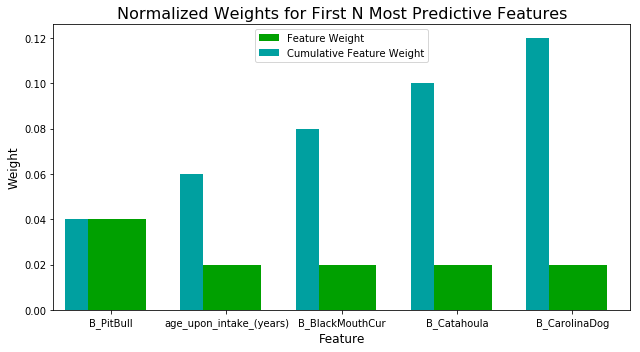

In [407]:
# Plot

feature_plot_count(importances, X_train, y_train,5)

In [262]:
print(importances)

[0.04 0.   0.   0.   0.   0.02 0.   0.   0.   0.02 0.02 0.   0.   0.02
 0.   0.02 0.   0.   0.   0.02 0.02 0.   0.02 0.02 0.   0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.   0.   0.02 0.02 0.   0.02 0.02 0.02 0.02
 0.   0.02 0.02 0.04 0.02 0.   0.02 0.02 0.   0.   0.   0.02 0.   0.02
 0.   0.02 0.02 0.   0.02 0.02 0.   0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02 0.02 0.   0.02 0.02 0.  ]


In [383]:
from sklearn.svm import SVC
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # TODO: Calculate the performance score between 'y_true' and 'y_predict'
    score = precision_score(y_true, y_predict)
    
    # Return the score
    return score

# Define the model (with default hyperparameters)
#model="RandomForestClassifier"
model="SVCClassifier"
if model=="RandomForestClassifier":
    clf = DecisionTreeClassifier(random_state=42)
else:
    if model=="SVCClassifier":
        clf = SVC(gamma=100, C=.9, kernel='rbf',random_state=3)

# Fit the model
clf.fit(X_train, y_train)

# Make predictions using the unoptimized and model
train_predictions = clf.predict(X_train)
test_predictions = clf.predict(X_test)


def fit_model(X, y, model):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    # sklearn version 0.18: ShuffleSplit(n_splits=10, test_size=0.1, train_size=None, random_state=None)
    # sklearn versiin 0.17: ShuffleSplit(n, n_iter=10, test_size=0.1, train_size=None, random_state=None)

    cv_sets = ShuffleSplit(n_splits = 10, test_size = 0.20, random_state = 0)
    cv_sets.get_n_splits(features_log_transformed)

    # Create a RF classifier object
    if model=="RandomForestClassifier":
        regressor = RandomForestClassifier()
         
        # Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
        params = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'n_estimators': [10,20,50,100,1000], \
               }
    else:
        if model=="SVCClassifier":
            regressor = SVC()
            params={'gamma': [10,20,50,75,90,100,120,150], 'C': [0.2,0.5,0.9,1.0], 'kernel': ['rbf']}
            #(gamma=100, C=.9, kernel='rbf',random_state=3
    
    # TODO: Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    # TODO: Create the grid search cv object --> GridSearchCV()
    # Make sure to include the right parameters in the object:
    # (estimator, param_grid, scoring, cv) which have values 'regressor', 'params', 'scoring_fnc', and 'cv_sets' respectively.
    grid = GridSearchCV(estimator=regressor, param_grid=params, scoring=scoring_fnc, cv=cv_sets )

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_




In [384]:
reg = fit_model(X_train, y_train,model)


# Produce the value for 'max_depth'
#print("Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth']))


In [385]:
print(reg.get_params())
#print("Parameter 'n_estimators' is {} for the optimal model.".format(reg.get_params()['n_estimators']))

{'C': 0.9, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 10, 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


In [388]:
clf.get_params()

{'C': 0.9,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'auto',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [408]:
clf_A = LogisticRegression(random_state = 123)
#clf_B = svm.SVC(gamma=100, C=.9, kernel='rbf',random_state=35)
clf_B =SVC(gamma=10, C=0.9, random_state = 345)
#clf_A = RandomForestClassifier(random_state=57,max_depth=5)
clf_C = AdaBoostClassifier(RandomForestClassifier(max_depth=3,n_estimators=10))

samples_100 = len(y_train)
samples_10 = int( .1 * samples_100 )
samples_1 = int (.01 * samples_100 )

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

        
 

LogisticRegression trained on 330 samples.
LogisticRegression trained on 3307 samples.
LogisticRegression trained on 33072 samples.
SVC trained on 330 samples.
SVC trained on 3307 samples.
SVC trained on 33072 samples.
AdaBoostClassifier trained on 330 samples.
AdaBoostClassifier trained on 3307 samples.
AdaBoostClassifier trained on 33072 samples.


In [390]:
import matplotlib.patches as mpatches


def evaluate(results, accuracy, precision, recall, f):

    """
    Visualization code to display results of various learners.
    
    inputs:
      - learners: a list of supervised learners
      - stats: a list of dictionaries of the statistic results from 'train_predict()'
      - accuracy: The score for the naive predictor
      - f1: The score for the naive predictor
    """
  
    # Create figure
    fig, ax = pl.subplots(2, 5, figsize = (17,11))
    
    # Constants
    bar_width = 0.3
    colors = ['#A00000','#00A0A0','#00A000','#B000B0','#0000B0']
    
    # Super loop to plot six panels of data
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['train_time', 'acc_train', 'f_train', 'precision_train','recall_train','pred_time', 'acc_test', 'f_test','precision_test','recall_test']):
            for i in np.arange(3):
                
                # Creative plot code
                ax[j//5, j%5].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
                ax[j//5, j%5].set_xticks([0.45, 1.45, 2.45])
                ax[j//5, j%5].set_xticklabels(["1%", "10%", "100%"])
                ax[j//5, j%5].set_xlabel("Training Set Size")
                ax[j//5, j%5].set_xlim((-0.1, 3.0))
    
    # Add unique y-labels
    ax[0, 0].set_ylabel("Time (in seconds)")
    ax[0, 1].set_ylabel("Accuracy Score")
    ax[0, 2].set_ylabel("F-score")
    ax[0, 3].set_ylabel("Precision Score")
    ax[0, 4].set_ylabel("Recall Score")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("Accuracy Score")
    ax[1, 2].set_ylabel("F-score")
    ax[1, 3].set_ylabel("Precision Score")
    ax[1, 4].set_ylabel("Recall Score")
    
    # Add titles
    ax[0, 0].set_title("Model Training")
    ax[0, 1].set_title("Accuracy Score on Training Subset")
    ax[0, 2].set_title("F-score on Training Subset")
    ax[0, 3].set_title("Precision on Training Subset")
    ax[0, 4].set_title("Recall on Training Subset")
    ax[1, 0].set_title("Model Predicting")
    ax[1, 1].set_title("Accuracy Score on Testing Set")
    ax[1, 2].set_title("F-score on Testing Set")
    ax[1, 3].set_title("Precision on Testing Subset")
    ax[1, 4].set_title("Recall on Testing Subset")
    
    # Add horizontal lines for naive predictors
    ax[0, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[0, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[0, 3].axhline(y = precision, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 3].axhline(y = precision, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[0, 4].axhline(y = recall, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 4].axhline(y = recall, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    
    # Set y-limits for score panels
    ax[0, 1].set_ylim((0, 1))
    ax[0, 2].set_ylim((0, 1))
    ax[0, 3].set_ylim((0, 1))
    ax[0, 4].set_ylim((0, 1))
    ax[1, 1].set_ylim((0, 1))
    ax[1, 2].set_ylim((0, 1))
    ax[1, 3].set_ylim((0, 1))
    ax[1, 4].set_ylim((0, 1))
    

    # Create patches for the legend
    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color = colors[i], label = learner))
    pl.legend(handles = patches, bbox_to_anchor = (-.80, 2.53), \
               loc = 'upper center', borderaxespad = 0., ncol = 3, fontsize = 'x-large')
    
    # Aesthetics
    pl.suptitle("Performance Metrics for Three Supervised Learning Models", fontsize = 16, y = 1.10)
    pl.tight_layout()
    pl.show()
    

def feature_plot(importances, X_train, y_train):
    
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:5]]
    values = importances[indices][:5]

    # Creat the plot
    fig = pl.figure(figsize = (9,5))
    pl.title("Normalized Weights for First Five Most Predictive Features", fontsize = 16)
    pl.bar(np.arange(5), values, width = 0.6, align="center", color = '#00A000', \
          label = "Feature Weight")
    pl.bar(np.arange(5) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    pl.xticks(np.arange(5), columns)
    pl.xlim((-0.5, 4.5))
    pl.ylabel("Weight", fontsize = 12)
    pl.xlabel("Feature", fontsize = 12)
    
    pl.legend(loc = 'upper center')
    pl.tight_layout()
    pl.show()  



In [409]:
from sklearn.naive_bayes import MultinomialNB
naive_bayes = MultinomialNB(fit_prior=False)
naive_results=train_predict(naive_bayes, len(y_train), X_train, y_train, X_test, y_test)
#naive_bayes.fit(X_train, y_train)

MultinomialNB trained on 33072 samples.


In [410]:
#print(naive_results)
naive_f_train=naive_results['f_train']
naive_acc_train=naive_results['acc_train']
naive_recall_train=naive_results['recall_train']
naive_precision_train=naive_results['precision_train']

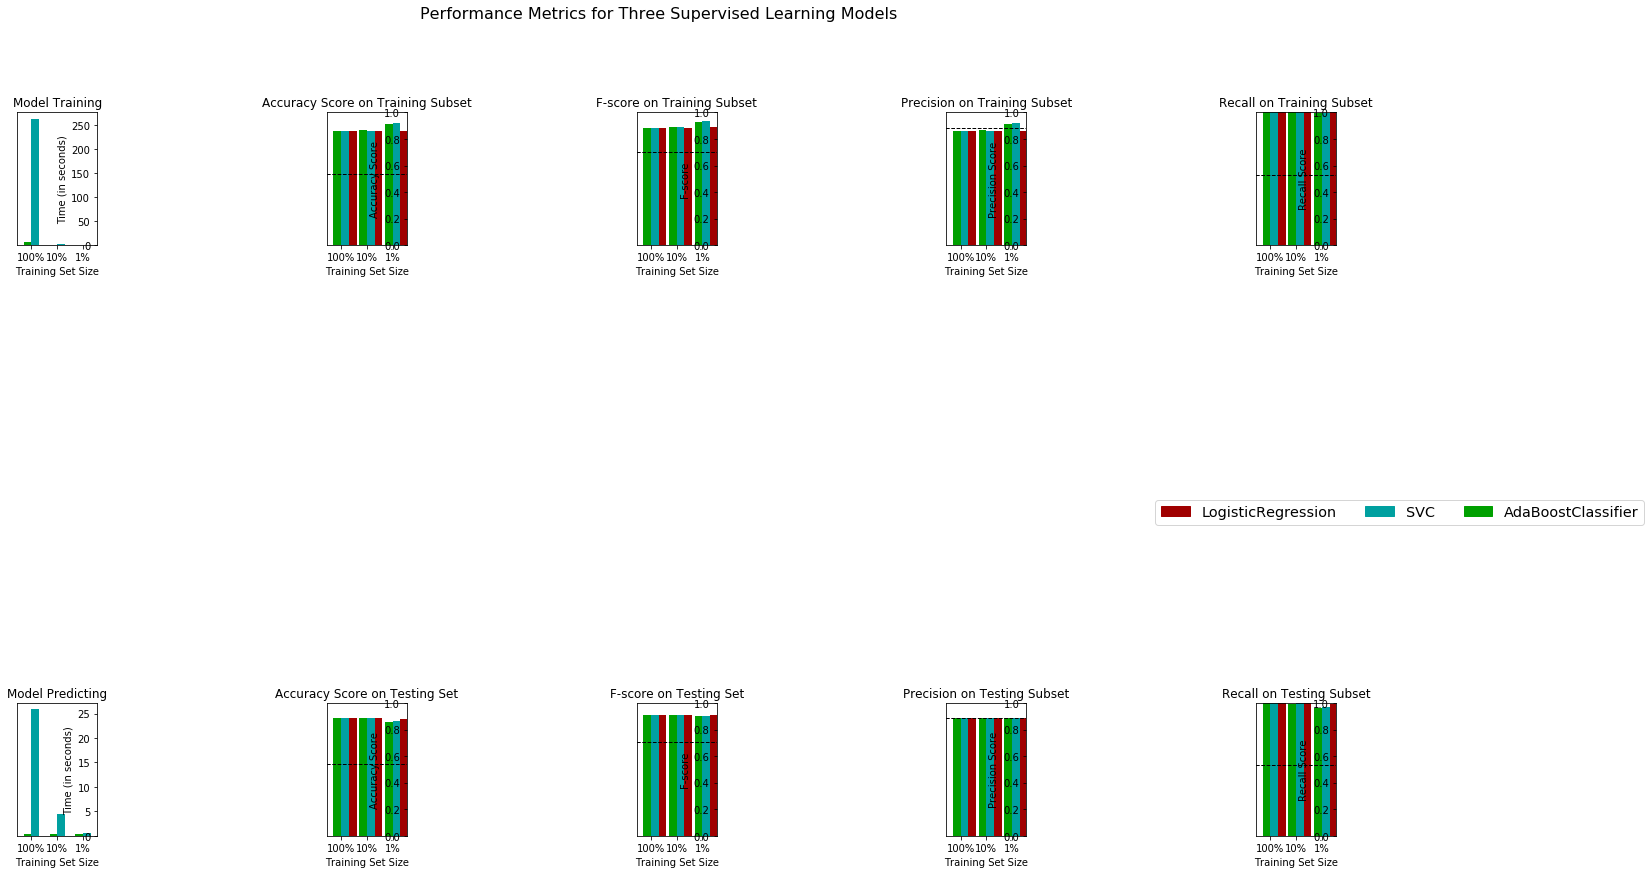

In [411]:
evaluate(results,naive_results['acc_train'],naive_results['precision_train'],naive_results['recall_train'],naive_results['f_train'])       

In [358]:
importances = clf.feature_importances_

In [359]:
import matplotlib.pyplot as pl
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import f1_score, accuracy_score


def distribution(data, transformed = False):
    """
    Visualization code for displaying skewed distributions of features
    """
    
    # Create figure
    fig = pl.figure(figsize = (11,5));

    # Skewed feature plotting
    for i, feature in enumerate(data.columns):
        ax = fig.add_subplot(1, 2, i+1)
        ax.hist(data[feature], bins = 25, color = '#00A0A0')
        ax.set_title("'%s' Feature Distribution"%(feature), fontsize = 14)
        ax.set_xlabel("Value")
        ax.set_ylabel("Number of Records")
        ax.set_ylim((0, 2000))
        ax.set_yticks([0, 500, 1000, 1500, 2000])
        ax.set_yticklabels([0, 500, 1000, 1500, ">2000"])

    # Plot aesthetics
    if transformed:
        fig.suptitle("Log-transformed Distributions of Continuous Data Features", \
            fontsize = 16, y = 1.03)
    else:
        fig.suptitle("Skewed Distributions of Continuous Data Features", \
            fontsize = 16, y = 1.03)

    fig.tight_layout()
    fig.show()




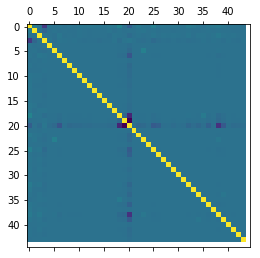

In [360]:
pl.matshow(dataDog.corr())
pl.show()

In [361]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(dataDog, 5))

Top Absolute Correlations
B_DomesticMediumHair     B_DomesticShorthair    0.605514
B_DomesticLonghair       B_DomesticShorthair    0.442187
B_DomesticShorthair      B_Siamese              0.376883
age_upon_intake_(years)  IT_Stray               0.330876
B_AmericanShorthair      B_DomesticShorthair    0.179853
dtype: float64


In [362]:
import matplotlib.pyplot as pl
import matplotlib.patches as mpatches
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = pl.subplots(figsize=(size, size))
    ax.matshow(corr)
    pl.xticks(range(len(corr.columns)), corr.columns);
    pl.yticks(range(len(corr.columns)), corr.columns);

###########################################
# Suppress matplotlib user warnings
# Necessary for newer version of matplotlib
import warnings
warnings.filterwarnings("ignore", category = UserWarning, module = "matplotlib")
#
# Display inline matplotlib plots with IPython
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
###########################################

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def filter_data(data, condition):
    """
    Remove elements that do not match the condition provided.
    Takes a data list as input and returns a filtered list.
    Conditions should be a list of strings of the following format:
      '<field> <op> <value>'
    where the following operations are valid: >, <, >=, <=, ==, !=
    
    Example: ["Sex == 'male'", 'Age < 18']
    """

    field, op, value = condition.split(" ")
    
    # convert value into number or strip excess quotes if string
    try:
        value = float(value)
    except:
        value = value.strip("\'\"")
    
    # get booleans for filtering
    if op == ">":
        matches = data[field] > value
    elif op == "<":
        matches = data[field] < value
    elif op == ">=":
        matches = data[field] >= value
    elif op == "<=":
        matches = data[field] <= value
    elif op == "==":
        matches = data[field] == value
    elif op == "!=":
        matches = data[field] != value
    else: # catch invalid operation codes
        raise Exception("Invalid comparison operator. Only >, <, >=, <=, ==, != allowed.")
    
    # filter data and outcomes
    data = data[matches].reset_index(drop = True)
    return data

def survival_stats(data, outcomes, key, filters = []):
    """
    Print out selected statistics regarding survival, given a feature of
    interest and any number of filters (including no filters)
    """
    
    # Check that the key exists
    if key not in data.columns.values :
        print("'{}' is not a feature of the Titanic data. Did you spell something wrong?".format(key))
        return False

    # Return the function before visualizing if 'Cabin' or 'Ticket'
    # is selected: too many unique categories to display
    if(key == 'Cabin' or key == 'PassengerId' or key == 'Ticket'):
        print("'{}' has too many unique categories to display! Try a different feature.".format(key))
        return False

    # Merge data and outcomes into single dataframe
    all_data = pd.concat([data, outcomes.to_frame()], axis = 1)
    
    # Apply filters to data
    for condition in filters:
        all_data = filter_data(all_data, condition)

    # Create outcomes DataFrame
    all_data = all_data[[key, 'Survived']]
    
    # Create plotting figure
    plt.figure(figsize=(8,6))

    # 'Numerical' features
    if(key == 'Age' or key == 'Fare'):
        
        # Remove NaN values from Age data
        all_data = all_data[~np.isnan(all_data[key])]
        
        # Divide the range of data into bins and count survival rates
        min_value = all_data[key].min()
        max_value = all_data[key].max()
        value_range = max_value - min_value

        # 'Fares' has larger range of values than 'Age' so create more bins
        if(key == 'Fare'):
            bins = np.arange(0, all_data['Fare'].max() + 20, 20)
        if(key == 'Age'):
            bins = np.arange(0, all_data['Age'].max() + 10, 10)
        
        # Overlay each bin's survival rates
        nonsurv_vals = all_data[all_data['Survived'] == 0][key].reset_index(drop = True)
        surv_vals = all_data[all_data['Survived'] == 1][key].reset_index(drop = True)
        plt.hist(nonsurv_vals, bins = bins, alpha = 0.6,
                 color = 'red', label = 'Did not survive')
        plt.hist(surv_vals, bins = bins, alpha = 0.6,
                 color = 'green', label = 'Survived')
    
        # Add legend to plot
        plt.xlim(0, bins.max())
        plt.legend(framealpha = 0.8)
    
    # 'Categorical' features
    else:
       
        # Set the various categories
        if(key == 'Pclass'):
            values = np.arange(1,4)
        if(key == 'Parch' or key == 'SibSp'):
            values = np.arange(0,np.max(data[key]) + 1)
        if(key == 'Embarked'):
            values = ['C', 'Q', 'S']
        if(key == 'Sex'):
            values = ['male', 'female']

        # Create DataFrame containing categories and count of each
        frame = pd.DataFrame(index = np.arange(len(values)), columns=(key,'Survived','NSurvived'))
        for i, value in enumerate(values):
            frame.loc[i] = [value, \
                   len(all_data[(all_data['Survived'] == 1) & (all_data[key] == value)]), \
                   len(all_data[(all_data['Survived'] == 0) & (all_data[key] == value)])]

        # Set the width of each bar
        bar_width = 0.4

        # Display each category's survival rates
        for i in np.arange(len(frame)):
            nonsurv_bar = plt.bar(i-bar_width, frame.loc[i]['NSurvived'], width = bar_width, color = 'r')
            surv_bar = plt.bar(i, frame.loc[i]['Survived'], width = bar_width, color = 'g')

            plt.xticks(np.arange(len(frame)), values)
            plt.legend((nonsurv_bar[0], surv_bar[0]),('Did not survive', 'Survived'), framealpha = 0.8)

    # Common attributes for plot formatting
    plt.xlabel(key)
    plt.ylabel('Number of Passengers')
    plt.title('Passenger Survival Statistics With \'%s\' Feature'%(key))
    plt.show()

    # Report number of passengers with missing values
    if sum(pd.isnull(all_data[key])):
        nan_outcomes = all_data[pd.isnull(all_data[key])]['Survived']
        print("Passengers with missing '{}' values: {} ({} survived, {} did not survive)".format( \
              key, len(nan_outcomes), sum(nan_outcomes == 1), sum(nan_outcomes == 0)))


